In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
import matplotlib.patheffects as pe

from omegaconf import OmegaConf
import os
import sys
sys.path.append('../')
from scripts.preprocessing import read_region_input_files, obtain_boxes_grouping, crop_region, crop_square
from scripts.clustering_utils import find_streamer_cluster
from scripts.plot_utils import *

from scipy.stats import percentileofscore
from cmap import Colormap, Color

%load_ext autoreload
%autoreload 2


In [10]:
def plot_hist(region, path, ax):
        
        data = pd.read_csv(os.path.join(path, 'outputs/train_data/', f'{region}.csv'), index_col=0)
        labels = np.load(os.path.join(path, 'outputs/labels/', f'{region}.npy'))

        streamers_cluster = find_streamer_cluster(data, labels)

        data = data[labels == streamers_cluster].sst

        # Define the range for the bins
        min_val, max_val = min(data), max(data)

        # Ensure 0 is a boundary and bins are evenly spaced
        bin_width = (max_val - min_val) / 30  # Define bin width for 30 bins
        num_bins_below_zero = int(np.ceil(-min_val / bin_width))
        num_bins_above_zero = int(np.ceil(max_val / bin_width))

        # Create bins
        bins_below_zero = -np.arange(0, num_bins_below_zero + 1) * bin_width
        bins_above_zero = np.arange(1, num_bins_above_zero + 1) * bin_width
        bins = np.sort(np.concatenate((bins_below_zero, bins_above_zero)))

        # Calculate the percentage of values > 0
        # percentage_greater_than_zero = (np.sum(data > 0) / len(data)) * 100

        # Calculate the quantile for 0
        quantile_at_zero = 100 - percentileofscore(data, 0)

        # Calculate histogram
        hist, edges = np.histogram(data, bins=bins, density = True)

        # Split histogram into negative and positive parts
        hist_negative = np.where(edges[:-1] < 0, hist, 0)
        hist_positive = np.where(edges[:-1] >= 0, hist, 0)

        # Plot the histogram
        ax.bar(edges[:-1], hist_negative, width=np.diff(edges), color='blue', alpha=0.6, label='Value < 0', align='edge')
        ax.bar(edges[:-1], hist_positive, width=np.diff(edges), color='red', alpha=0.6, label='Value ≥ 0', align='edge')

        # Add external edges
        ax.step(edges, np.append(hist, hist[-1]), where='post', color='black', lw=.75)

        # Add percentage annotation
        ax.axvline(0, color='black', linestyle='--', label='Zero Threshold')
        ax.annotate(f"{quantile_at_zero:.2f}%", color = 'red',
                xy=(3.5, 0.2), #xytext=(min_val * 0.5, max(hist) * 0.9),
                #arrowprops=dict(facecolor='black', arrowstyle='->'), 
                fontsize=15, ha = 'center')
        
        return ax


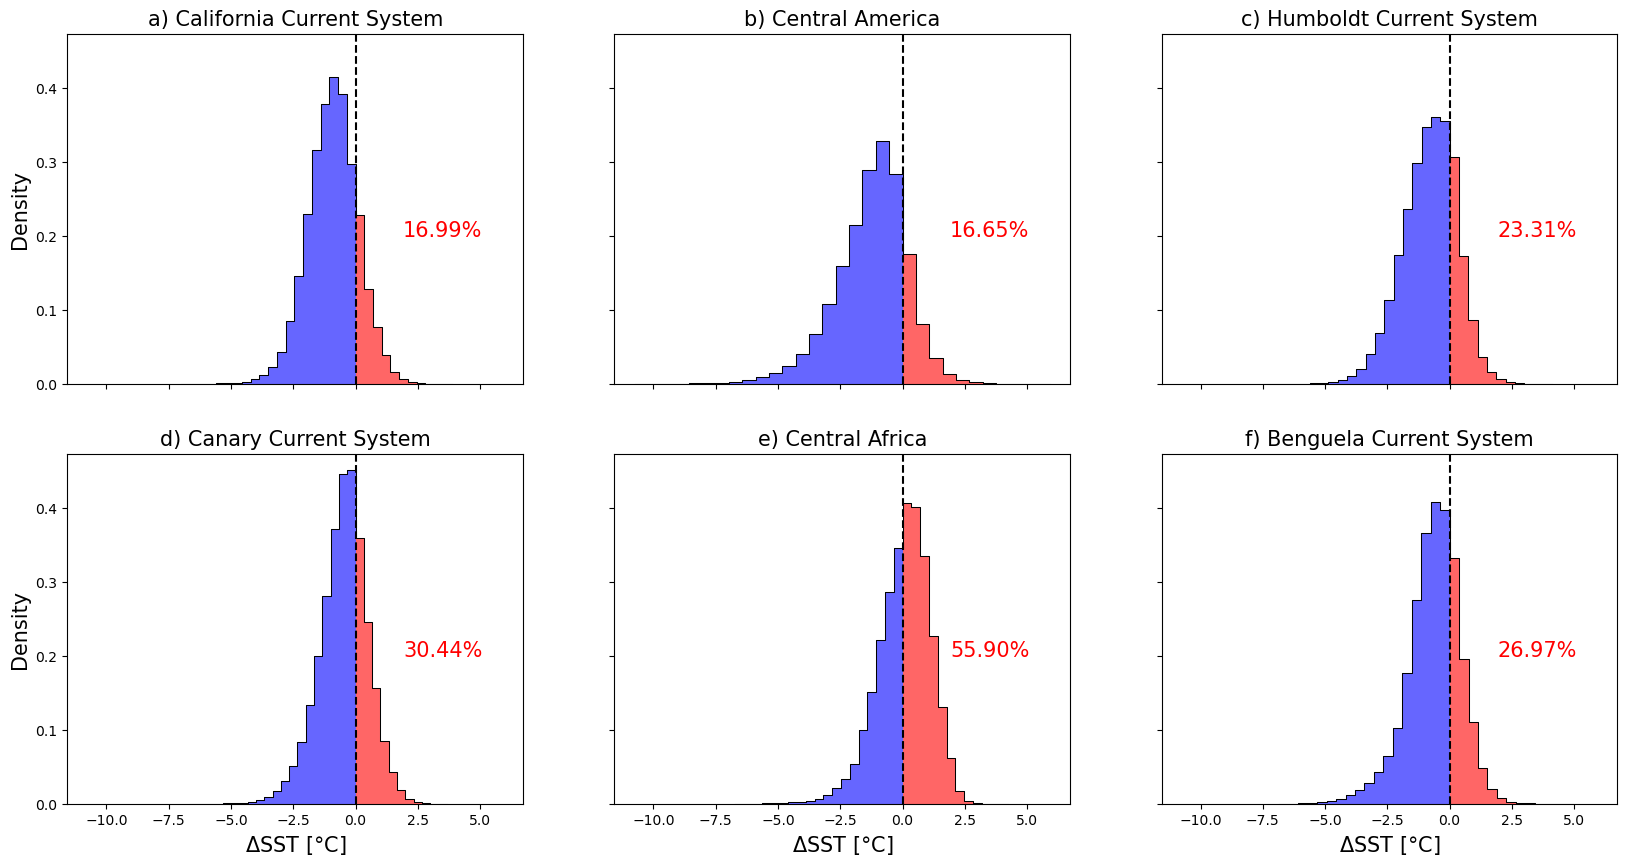

In [11]:
data_paths = ['../sensitivity_test_years/pacific/10years/', '../sensitivity_test_years/atlantic/10years/']

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = [20,10], sharex = True, sharey = True)



for i, path in enumerate(data_paths):
    
    regions = read_region_input_files(os.path.join(path, 'regions.input'))

    for j, region in enumerate(regions.keys()):

        plot_hist(region, path, ax[i,j])
        ax[i,j].set_title(region, fontsize = 15)

for a, l in zip(ax[0,:], ['a) ', 'b) ', 'c) ']):
    a.set_title(l + a.get_title(), fontsize = 15)

for a, l in zip(ax[1,:], ['d) ', 'e) ', 'f) ']):
    a.set_title(l + a.get_title(), fontsize = 15)
    a.set_xlabel('$\Delta$SST [°C]', fontsize = 15)

ax[0,0].set_ylabel('Density', fontsize = 15)
ax[1,0].set_ylabel('Density', fontsize = 15)
    
plt.savefig('../images/delta_sst_distributions.jpg', bbox_inches = 'tight')

In [24]:


def plot_clustered_space(train_data, labels, pipeline, axs, fontsize = 13):
    
    cols = map_colors_to_labels(train_data, labels)

    cmap = colors.ListedColormap(cols)

    
    # CENTER B PLOT
    axs["B"].set_xlabel("$\Delta$Chl [mg m$^{-3}$]", fontsize = fontsize)
    axs["B"].set_ylabel("$\Delta$SST [°C]", fontsize = fontsize)
    
    axs["B"].plot(train_data["chl"], train_data["sst"], ".", 
                  markersize = 3, alpha = .7, zorder = -2,
                 color = "dimgray")
    
    
    yabs_max = abs(max(axs["B"].get_ylim(), key=abs))
    xabs_max = abs(max(axs["B"].get_xlim(), key=abs))
    
    axs["B"].set_ylim(ymin=-yabs_max, ymax=yabs_max)
    axs["B"].set_xlim(xmin=-xabs_max, xmax=xabs_max)
    
    axs["B"].hlines(0, xmin = -xabs_max, xmax = xabs_max, color = "dimgray", linestyle = "dashed", linewidth = .5)
    axs["B"].vlines(0, ymin = -yabs_max, ymax = yabs_max, color = "dimgray", linestyle = "dashed", linewidth = .5)
    h = 0.02  # step size of the mesh
    
    xx, yy = np.meshgrid(np.arange(-xabs_max, xabs_max, h), np.arange(-yabs_max, yabs_max, h))
    Z = pipeline.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    axs["B"].contour(xx, yy, Z, alpha=0.5, colors = "black", linewidths = .5)
    axs["B"].imshow(
            Z,
            interpolation="nearest",
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=cmap,
            aspect="auto",
            origin="lower",
            zorder = -1, alpha = 0.5
        )
    
    centroids = pipeline["km"].cluster_centers_

    for c, i in cols.items():
        if c == 'green':
            axs["B"].text(20, -4, str(i), ha = "center", va = "center", size = 15, 
                          color = c, path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        elif c == 'royalblue':
            axs["B"].text(-5, -6, str(i), ha = "center", va = "center", size = 15, 
                          color = c, path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        elif c == 'salmon':
            axs["B"].text(-20, 4, str(i), ha = "center", va = "center", size = 15, 
                          color = c, path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        elif c == 'yellow':
            axs["B"].text(0, 0, str(i), ha = "center", va = "center", size = 15, 
                          color = c, path_effects=[pe.withStroke(linewidth=1, foreground="black")])
    
    # for i, c in enumerate(centroids):
    #     c = pipeline["scaler"].inverse_transform(c.reshape(1,-1)).flatten()
    #     axs["B"].text(c[0], c[1], str(i), ha = "center", va = "center")
    
    chl_x = np.linspace(train_data["chl"].min(), train_data["chl"].max(), 50)
    sst_x = np.linspace(train_data["sst"].min(), train_data["sst"].max(), 50)
    # chl_kde = gaussian_kde(train_data["chl"])
    # sst_kde = gaussian_kde(train_data["sst"])
    
    # UPPER CHL KERNEL PLOT
    axs["A"].set_xticks([])
    axs["A"].set_xlim(xmin=-xabs_max, xmax=xabs_max)
    axs["A"].hist(train_data["chl"], alpha = .5, density = True, bins = 20, color = 'grey')
    #axs["A"].plot(chl_x, chl_kde(chl_x), color = "black")
    axs["A"].vlines(0, ymin = 0, ymax = max(axs["A"].get_ylim(), key=abs), 
                    color = "dimgray", linestyle = "dashed", linewidth = .5)
    
    
    # RIGHT SST KERNEL PLOT
    axs["C"].set_yticks([])
    axs["C"].set_ylim(ymin=-yabs_max, ymax=yabs_max)
    #axs["C"].plot(sst_kde(sst_x), sst_x, color = "black")
    axs["C"].hist(train_data["sst"], alpha = .5, density = True, bins = 20, orientation = "horizontal", color = 'grey')
    axs["C"].hlines(0, xmin = 0, xmax = max(axs["C"].get_xlim(), key=abs), 
                    color = "dimgray", linestyle = "dashed", linewidth = .5)
    
    
    # UPPER RIGHT POPULATION PLOT
    axs["D"].set_ylim([0,50])
    axs["D"].set_yticks([0, 25, 50])
    counts = pd.DataFrame({"labels" : labels}).value_counts().sort_index()
    perc_counts = counts / len(labels) * 100
    
    axs["D"].bar(range(len(centroids)), perc_counts, color = cols, edgecolor = "black", alpha = 0.7)
    axs["D"].set_xticks(range(0, len(perc_counts)))
    axs["D"].xaxis.set_ticks_position('none') 
    axs["D"].tick_params(axis='x', which='major', pad=-2)
    axs["D"].yaxis.tick_right()
    axs["D"].set_yticklabels(["0%", "25%", "50%"])

    return fig, axs

from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_fils(ax, date, folder_path, group_idx, norm_chl, norm_sst, bigbox):
    
    region = read_region_input_files(os.path.join(folder_path, 'regions.input'))

    bathymetry = xr.open_dataarray('/data01/benassi/export-biomass/data/processed/bathymetry.nc')

    boxes = [box for boxes in region.values() for box in boxes]
    groups = obtain_boxes_grouping(region)[group_idx]


    chl = crop_region('/data01/benassi/export-biomass/data/processed/chl_2003-2023.zarr', box = bigbox)
    sst = crop_region('/data01/benassi/export-biomass/data/processed/sst_2003-2023.zarr', box = bigbox)

    bathy_mask = crop_square(bathymetry, box = bigbox, engine = 'netcdf4') 
    chl, sst = chl.where(bathy_mask < cfg.ref_depth), sst.where(bathy_mask < cfg.ref_depth)


    c_chl = ax[0].contourf(chl.longitude, chl.latitude, chl.sel(time = date), 
                           cmap = Colormap('chrisluts:I_Forest').to_mpl(), 
                           norm = norm_chl, 
                           extend = 'max', 
                           levels = np.linspace(0, norm_chl.vmax, 50))
    
    c_sst = ax[1].contourf(sst.longitude, sst.latitude, sst.sel(time = date), 
                           cmap = Colormap('cmocean:balance').to_mpl(), 
                           norm = norm_sst, 
                           extend = 'both', 
                           vmin = norm_sst.vmin,
                           vmax = norm_sst.vmax,
                           levels = np.linspace(norm_sst.vmin, norm_sst.vmax, 50))

    for idx in groups:
        if 'pacific' in folder_path:
            region_name = 'pacific'
        elif 'atlantic' in folder_path:
            region_name = 'atlantic'
        else:
            raise ValueError('No region found')
        mask = xr.open_dataarray(os.path.join(folder_path, f'outputs/streamers_masks/box_{idx}.nc')).sel(time = date).astype(int)
        warm_mask = xr.open_dataarray(f'{region_name}/warm_fils/box_{idx}.nc').sel(time = date).astype(int)
        cold_mask = mask - warm_mask

        # Combine masks into a single mask: 0 = background, 1 = red, 2 = blue
        combined_mask = warm_mask * 1 + cold_mask * 2

        # Define a custom colormap
        cmap = ListedColormap(['white', Color('red'), Color('blue')])
        norm = BoundaryNorm([0, 1, 2, 3], cmap.N)  # Define boundaries for color mapping
        for a in ax[:2]:
            a.contour(chl.longitude, chl.latitude, bathy_mask, [cfg.ref_depth], colors = "red", linestyles = "solid", linewidths = .6)
            a.contour(mask.longitude, mask.latitude, mask, levels = [0.1, 1], colors = 'black')
            a.set_xlim([bigbox[0], bigbox[1]])
            a.set_ylim([bigbox[2], bigbox[3]])

        
        mesh = ax[2].pcolormesh(
            combined_mask.longitude, combined_mask.latitude, combined_mask,
            cmap=cmap, norm = norm
        )
        ax[2].set_xlim([bigbox[0], bigbox[1]])
        ax[2].set_ylim([bigbox[2], bigbox[3]])


    cb_chl = plt.colorbar(c_chl, ax = ax[0], orientation = 'horizontal', shrink = .8)
    cb_chl.set_label(label = 'Chlorophyll concentration [mg m$^{-3}$]', fontsize = 12)
    cb_sst = plt.colorbar(c_sst, ax = ax[1], orientation = 'horizontal', shrink = .8)
    cb_sst.set_label(label = 'Sea surface temperature [°C]', fontsize = 12)
    
    cb_mesh = plt.colorbar(mesh, ax=ax[2], orientation = 'horizontal', shrink = .8, label='')

    cb_chl.ax.set_xticks(np.arange(0, 3.5, 0.5))
    cb_sst.ax.set_xticks(np.arange(10, 30, 5))
    cb_mesh.ax.set_xticks([1.5, 2.5], labels = ['$\Delta$SST $\geq$ 0', '$\Delta$SST < 0'], fontsize = 12)

    handles = [Line2D([0], [0], linestyle='solid', label = f'Reference depth = {cfg.ref_depth} m', color = 'red'),
            Line2D([0], [0], linestyle='solid', label = f'Streamers mask', color = 'black')]
    ax[0].legend(handles = handles, loc = 'lower left')#, ncol=2, prop = {'size' : 20})
    #plt.savefig('images/california_example_coldfils.jpg', bbox_inches = 'tight')
    return ax

In [25]:
cfg = OmegaConf.load('glob_config.yaml')


/data01/benassi/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


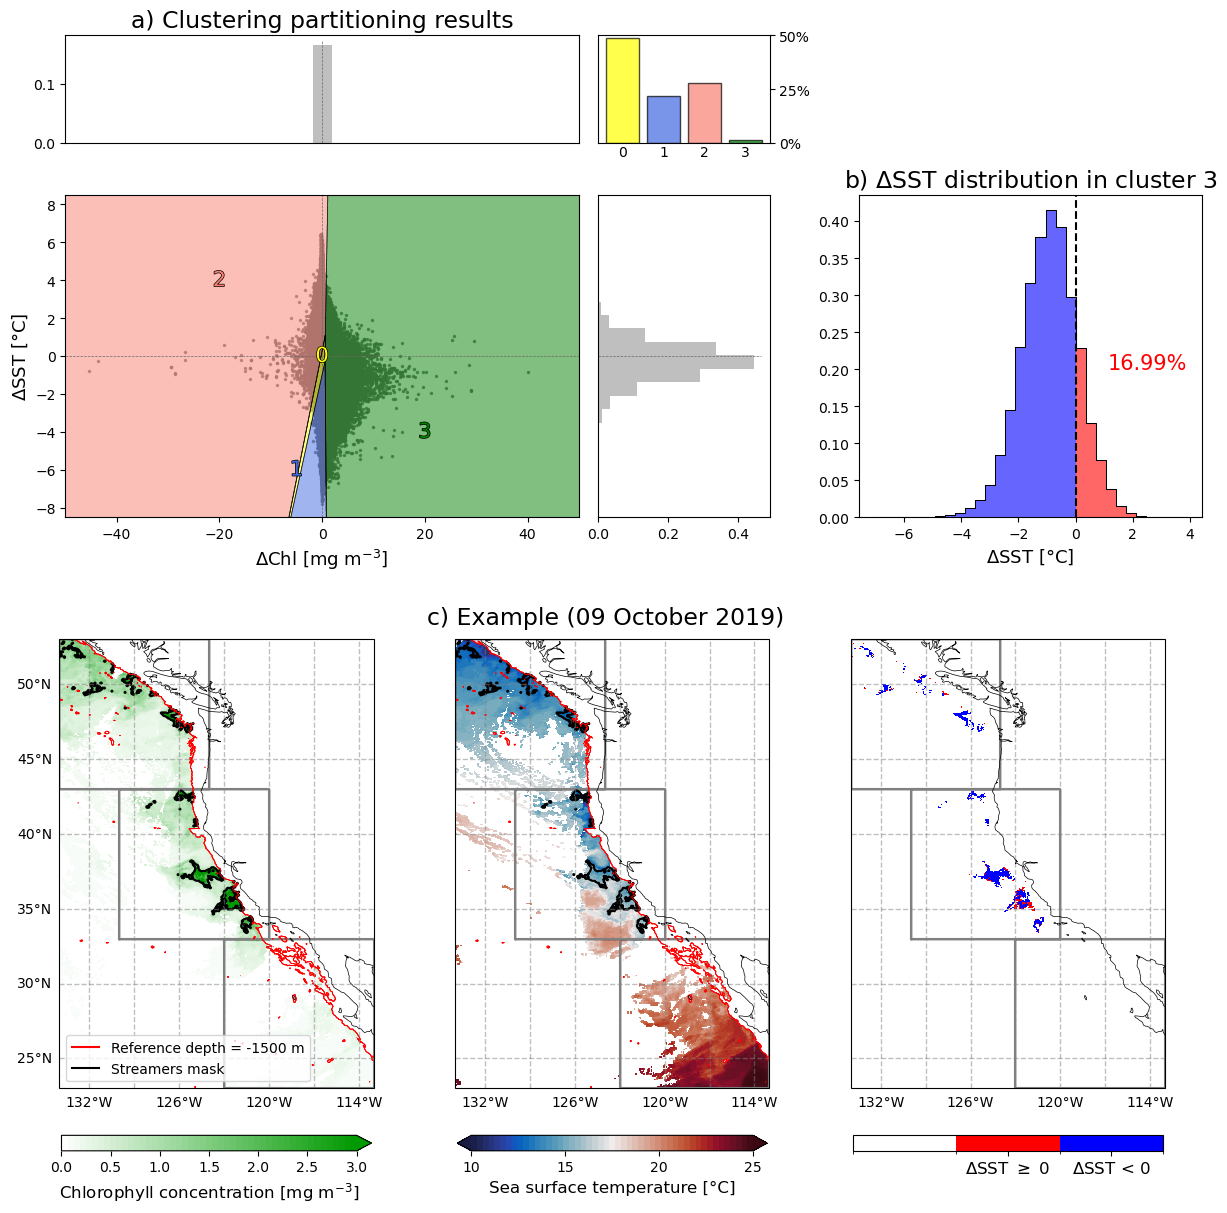

In [26]:

fig = plt.figure(layout='constrained', figsize=(12, 12))

# Define width ratios and overall layout
subfigs = fig.subfigures(2, 1, hspace=.1)#, width_ratios=[1, 1.5])

axs = subfigs[0].subplot_mosaic("""AAAD..
                                   BBBCEE
                                   BBBCEE
                                   BBBCEE
                                   """)

path = '/data01/benassi/export-biomass/final_version/sensitivity_test_years/pacific/10years/'

region = read_region_input_files(os.path.join(path, 'regions.input'))['California Current System']

train_data = pd.read_csv(os.path.join(path, 'outputs/train_data/California Current System.csv'))
labels = np.load(os.path.join(path, 'outputs/labels/California Current System.npy'))
pipeline = joblib.load(os.path.join(path, 'outputs/models/California Current System.joblib'))

plot_clustered_space(train_data, labels, pipeline, axs)
plot_hist('California Current System', path, ax = axs["E"])
axs['B'].set_xlim([-50, 50])
axs['E'].set_xlabel('$\Delta$SST [°C]', fontsize = 13)
axs['A'].set_title('a) Clustering partitioning results', fontsize = 17)
axs['E'].set_title('b) $\Delta$SST distribution in cluster 3', fontsize = 17)


axs = subfigs[1].subplots(ncols = 3, subplot_kw = {'projection' : PlateCarree()})

for a in axs:
    a.coastlines(linewidths=0.5, zorder = 1000)
    a.tick_params(axis="both", labelsize=15)
    gl = a.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder = 2, draw_labels = True)
    gl.top_labels = False
    gl.right_labels = False
    for box in region:
        plot_boxes(a, box, 'grey', None, x_offset = 0, y_offset = 0, add_num = False, lwd = 1)
    if a != axs[0]:
        gl.left_labels = False

norm_chl = Normalize(vmin = 0, vmax = 3)
norm_sst = Normalize(vmin = 10, vmax = 25)

bigbox = (-134, -113, 23, 53)
date = pd.to_datetime('2019-10-9')

plot_fils(axs, date, path, 0, norm_chl, norm_sst, bigbox)

subfigs[1].suptitle(f"c) Example ({date.strftime('%d %B %Y')})", y = 1.05, fontsize = 17)

plt.savefig('../images/fig2_california_clustering.jpg', bbox_inches = 'tight')